# Voting

In [407]:
# Importing the libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

f_size = 11
# Importing the dataset
dataset = pd.read_csv('CVDdataset.csv') #11
# dataset = pd.read_csv('CVD dataset-plin-7-9.csv') #14
# dataset = pd.read_csv('CVD-dataset-plin-0-4-6-7-9.csv') #11
# dataset = pd.read_csv('CVD dataset2.csv')
# dataset = pd.read_csv('CVD-dataset-2-3-11-13-15.csv')
# dataset = pd.read_csv('CVD dataset-plin-4-7-9.csv') #διαβάζω το dataset που δεν περιλαμβανει τα features 7 και 9
# dataset = pd.read_csv('CVD-dataset-1-2-3-5-10-11-12-13-14-15.csv')
data=dataset.iloc[:, :].values
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, f_size].values
# X = dataset.iloc[:, [ 0, 1, 2, 5, 10, 11, 13, 15]].values

rows = len(data)    # 3 rows in your example
cols = len(data[0])

In [408]:
# dataset.boxplot(column = 'Age', by = 'CVD prediction');
# plt.title('')
# plt.suptitle('Age')
# # dataset.boxplot(grid=False, rot=60, fontsize=15,figsize=(20,10));

In [409]:
dataNoCvd = data[~(data[:,f_size] > 0.0)]
dataCvd = data[~(data[:,f_size] < 1.0)]
rowsNoCvd = len(dataNoCvd)    
rowsCvd = len(dataCvd)
print(rowsNoCvd)
print(rowsCvd)
# print(dataNoCvd)
# print(dataCvd)

519
41


In [410]:
def find_NoCvd_limitsArray(i,DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue):
    if i>0 :
        DownNoCvd = UpNoCvd
        UpNoCvd= fold_NoCvd_total+UpNoCvd
    if i < fold_NoCvd_residue :
        UpNoCvd+= 1
#     print("NoCvd limits, Down :",DownNoCvd,"Up ",UpNoCvd)
    return   DownNoCvd, UpNoCvd   
 
def find_Cvd_limitsArray(i,DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv):
    if i>0 :
        DownCvd = UpCvd
        UpCvd= fold_Cvd_total+UpCvd
    if i >= cv - fold_Cvd_residue :
         UpCvd+= 1     
#     print("Cvd limits, Down :",DownCvd,"Up ",UpCvd)
    return   DownCvd, UpCvd  

def find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1=dataNoCvd[DownNoCvd:UpNoCvd,:]
    temp2=dataCvd[DownCvd:UpCvd,:]
    temp3=np.concatenate((temp1, temp2))
#     print(len(temp1),"  ",len(temp2),"  ",len(temp3))
    return temp3

def find_trainSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
    temp3 = np.concatenate((temp1, temp2))
#     print(len(temp1),"  ",len(temp2),"  ",len(temp3))
    return temp1, temp2, temp3

def find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
#     print("len 1-2:",len(temp1),len(temp2))
    temp3 = np.delete(temp1, slice(0, 46), axis=0)
    temp4 = np.delete(temp2, slice(0, 4), axis=0)
#     print("len 3-4:",len(temp3),len(temp4))
    temp5 = np.concatenate((temp3, temp4))
#     print(len(temp5))
    return temp3, temp4, temp5

In [411]:
def create_train_test_sets(f_size,cv,dataNoCvd,dataCvd,val_ratio):
    test_total = []
    train_total = []
    train_total_Cvd = []
    train_total_NoCvd = []
    validation_total = []
    
    rowsNoCvd = len(dataNoCvd)    
    rowsCvd = len(dataCvd)

    fold_Cvd_total = rowsCvd//cv
    fold_Cvd_residue= rowsCvd%cv
    print("fold_Cvd_total  :",fold_Cvd_total," fold_Cvd_residue  :",fold_Cvd_residue)

    fold_NoCvd_total = rowsNoCvd//cv
    fold_NoCvd_residue= rowsNoCvd%cv
    print("fold_NoCvd_total:",fold_NoCvd_total,"fold_NoCvd_residue:",fold_NoCvd_residue)
    
    Cvd_val = round(504*val_ratio*(rowsCvd/len(data)))
    noCvd_val = round(504*val_ratio)-Cvd_val
#     print(noCvd_val)
    
    DownNoCvd=0
    DownCvd=0
    UpNoCvd = fold_NoCvd_total
    UpCvd = fold_Cvd_total

    for i in range(cv):
        X_test = []
        y_test = []
        X_train = []
        y_train = []
        X_val = []
        y_val = []
#         print("============",i,"==============")
        DownNoCvd, UpNoCvd = find_NoCvd_limitsArray(i, DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue)
        DownCvd, UpCvd = find_Cvd_limitsArray(i, DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv)
#         print(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
        testSubset_total = find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd)        
        
        if i!=9:
        #όταν δεν είμαστε στο 10ο fold(ξεκινάμε από 0) παίρνουμε τα επόμενα 56 και 4 instaces για το validation set
            validationSubset_total = find_testValSubset(UpNoCvd,UpNoCvd+noCvd_val,UpCvd,UpCvd+Cvd_val,dataNoCvd,dataCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset(DownNoCvd,UpNoCvd+noCvd_val,DownCvd,UpCvd+Cvd_val,dataNoCvd,dataCvd)
        else:
        #όταν είμαστε στο 10ο fold παίρνουμε τα προηγούμενα 56 και 4 instaces για το validation set
#         DownNoCvd-noCvd_val,DownNoCvd,DownCvd-Cvd_val,DownCvd
            validationSubset_total = find_testValSubset(0,noCvd_val,0,Cvd_val,dataNoCvd,dataCvd)
            print(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset1(DownNoCvd,UpNoCvd,DownCvd,UpCvd,dataNoCvd,dataCvd)
    
    #creating X_train, y_train, X_test, y_test
        X_test.append(np.delete(testSubset_total, f_size, axis=1))
        y_test_temp = np.delete(testSubset_total, slice(0, f_size), axis=1)
        y_test.append(np.reshape(y_test_temp, len(y_test_temp)))
        X_test_temp = np.array(X_test)
        X_test = X_test_temp[0]
        y_test_temp = np.array(y_test)
        y_test = y_test_temp[0]
        
        X_val.append(np.delete(validationSubset_total, f_size, axis=1))
        y_val_temp = np.delete(validationSubset_total, slice(0, f_size), axis=1)
        y_val.append(np.reshape(y_val_temp, len(y_val_temp)))
        X_val_temp = np.array(X_val)
        X_val = X_val_temp[0]
        y_val_temp = np.array(y_val)
        y_val = y_val_temp[0]
        
        X_train.append(np.delete(trainSubset_total, f_size, axis=1))
        y_train_temp = np.delete(trainSubset_total, slice(0, f_size), axis=1)
        y_train.append(np.reshape(y_train_temp, len(y_train_temp)))
        X_train_temp = np.array(X_train)
        X_train = X_train_temp[0]
        y_train_temp = np.array(y_train)
        y_train = y_train_temp[0]
        
    #add every subset in a list so we can handle thm later 
        test_total.append([X_test,y_test])
        validation_total.append([X_val,y_val])
        train_total.append([X_train,y_train]) 
        train_total_NoCvd.append(trainSubset_NoCvd)
        train_total_Cvd.append(trainSubset_Cvd)
    return train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd

In [412]:
train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd = create_train_test_sets(f_size,10,dataNoCvd,dataCvd,0.1)

fold_Cvd_total  : 4  fold_Cvd_residue  : 1
fold_NoCvd_total: 51 fold_NoCvd_residue: 9
468 519 36 41


In [413]:
# Chech ratio in each train and test set
def find_ratio(index_list):
    one = 0
    lenght=len(index_list[0])
    for i in range(lenght):
#         print(index_list[1])
        if index_list[1][i] == 1.0 :
            one+= 1
    ratio = one/lenght
    return ratio

for i in range(10):
    print(len(train_total[i][0]))
    ratio = find_ratio(train_total[i])
    print("ratio in train set:", ratio)
    ratio = find_ratio(test_total[i])
    print("ratio in test set:", ratio)
    ratio = find_ratio(validation_total[i])
    print("ratio in validation set:", ratio)

454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in vali

In [455]:
import matplotlib.pyplot as plt
import shap
from matplotlib import pyplot
from xgboost import plot_importance
import math

def predict_weighted_average(models,X,weights):
    y_pred = []
    y_pred_prob = []
    y_pred_models = []
    y_pred_models1 = []
    models_size = len(models)
    X_size = len(X)
            
    for i in range(models_size):
        y_pred_models.append(models[i].predict(X,output_margin=True))  
        y_pred_models1.append(models[i].predict_proba(X)[:,1])
        
    
    
    total_shap_values = []
    total_expected_value = 0
    for i in range(models_size):
        explainer = shap.TreeExplainer(models[i],feature_perturbation = "tree_path_dependent")
#         explainer = shap.TreeExplainer(models[i],feature_perturbation="interventional",model_output="probability")
        # calculate shap values. This is what we will plot.
        # Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
         
        pp =models[i].get_booster().get_score(importance_type="cover")
#         print(pp)
        p = fill_importances(pp)
#         print(p)
        for key in p:
            p[key] = p[key]*weights[i]*0.1
            
        if(i==0):
             importances = p.copy()
        else:
            for key in importances:
                importances[key] += p[key]
   
            
        shap_values = explainer.shap_values(X)
        shap_values_auc = [[l*weights[i] for l in k] for k in shap_values]
        
        if(i==0):
             total_shap_values = shap_values_auc.copy()
        else:
            for a in range(len(total_shap_values)):
                for b in range(len(total_shap_values[0])):
                     total_shap_values[a][b] += shap_values_auc[a][b]
        total_expected_value += explainer.expected_value*weights[i] 
#         print("explainer.expected_value",explainer.expected_value)
  
    feature_names = ['Age','DD','BMI','Smoking','ypolip','PulsBP','aca0','gla0','chl0','tg0','hdl0']
    
    
 
    t_shap_values = numpy.array(total_shap_values)
    
#     shap.summary_plot(t_shap_values, X,feature_names)  
    

#     shap.force_plot(total_expected_value, t_shap_values[1,:], X[1],feature_names,matplotlib=True,link='logit')
#     shap_display = shap.force_plot(total_expected_value, t_shap_values, X)

#     display(shap_display)
    

            
            
        
    for j in range(X_size):
        sum = 0
        sum1 = 0
        for i in range(models_size):
            sum = sum + y_pred_models[i][j]*weights[i]
            sum1 = sum1 + y_pred_models1[i][j]*weights[i]
        avr = sum
#         /models_size
        pred_prob = math.exp(avr)/(1 + math.exp(avr))
        y_pred_prob.append(pred_prob)
        
        if avr>= 0 :
            y_pred.append(1.)
#             if(j==1):
#                 print("prediction YES")
#                 print(avr)
#                 print(pred_prob)
#                 print(sum1)
        else:
            y_pred.append(0.)
#             if(j==1):
#                 print("prediction NO")
#                 print(avr)
#                 print(pred_prob)
#                 print(sum1)
    return y_pred,t_shap_values,importances,y_pred_prob, total_expected_value

In [456]:
def fill_importances(p):
        if p.get("f0")== None:
            p['f0'] = 0
        if p.get("f1")== None:
            p['f1'] = 0
        if p.get("f2")== None:
            p['f2'] = 0
        if p.get("f3")== None:
            p['f3'] = 0
        if p.get("f4")== None:
            p['f4'] = 0
        if p.get("f5")== None:
            p['f5'] = 0
        if p.get("f6")== None:
            p['f6'] = 0
        if p.get("f7")== None:
            p['f7'] = 0
        if p.get("f8")== None:
            p['f8'] = 0
        if p.get("f9")== None:
            p['f9'] = 0
        if p.get("f10")== None:
            p['f10'] = 0
        return p

In [457]:
from xgboost import XGBClassifier


def my_fit(ratio,dataNoCvd,dataCvd, validation_total, params):   
    Subarray=[]
    models = []
    
    rowsNoCvd = len(dataNoCvd)    
    rowsCvd = len(dataCvd)
#     print("Size of NoCvd cases in train set:",rowsNoCvd)
#     print("Size of Cvd cases in train set  :",rowsCvd)
#     print("validation_total",len(validation_total[0][0]))


    numOfSubsamples = rowsNoCvd//(rowsCvd*ratio)
    numOfSubsamples= int(numOfSubsamples)
    SubNoCvd = rowsNoCvd//numOfSubsamples
    residue = rowsNoCvd- SubNoCvd*numOfSubsamples


    Up = 0
    
    for i in range(numOfSubsamples):
        
        classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=params[5],
                  colsample_bynode=1, colsample_bytree=params[8], gamma=params[4],
                  learning_rate=params[0], max_delta_step=0, max_depth=params[1],
                  min_child_weight=params[3], missing=None, n_estimators=params[2], n_jobs=1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=params[9], reg_lambda=params[6], scale_pos_weight=params[7], seed=None,
                  silent=None, subsample=params[10], verbosity=1)

    #Creating the training set for each model
        Down = Up
        Up= Up + SubNoCvd
        if i < residue :
            Up+= 1
        
#         print(Down)
#         print(Up)
        
        Sub1=dataNoCvd[Down:Up,:]
        Sub2=np.concatenate((Sub1, dataCvd))
        Subarray.append(Sub2)
        
    #Dividing to X and y of the previous traing set    
        X=np.delete(Subarray[i], f_size, axis=1)
        y=np.delete(Subarray[i], slice(0, f_size), axis=1)
        y=np.reshape(y, len(y))
        
        X_val = validation_total[i][0]
        y_val = validation_total[i][1]
#         print(len(X),len(X_val))
        eval_set  = [(X,y), (X_val,y_val)]
        
        classifier.fit( X, y, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=50,verbose = False)
#         classifier.fit( X, y)

        
        models.append(classifier)

        
    return models 

In [458]:
import math

def my_brier_score(y_test, y_pred_prob):
    sq_sum = 0
    for i in range(len(y_test)):
        dif = y_pred_prob[i] - y_test[i]
        sq_sum += math.pow(dif, 2)
    brier_sc = sq_sum/len(y_test)
    
    return brier_sc      

In [480]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from sklearn import metrics
from sklearn.metrics import brier_score_loss
import xlsxwriter

def my_cross_val( cv, train_total, test_total, train_total_NoCvd, train_total_Cvd,params, weights):
    accuracy = []
    specificity = []
    sensitivity = []
    auc = []
    brier_score = []
    cv_total_shap_values = []
    X_shap_total = []
    y_pred_prob_total = []
    cv_expected_value = 0
    # print(X)
    for i in range(cv):
#         X_train = train_total[i][0]
#         y_train = train_total[i][1]
        X_test = test_total[i][0]
        y_test = test_total[i][1]
        


        models = my_fit( 2, train_total_NoCvd[i], train_total_Cvd[i], validation_total,params)
    
        
        
        
        y_pred,shap_values,importances,y_pred_prob, total_expected_value = predict_weighted_average(models,X_test,weights)
        
#         print(len(shap_values[0]))
#         print(len(shap_values))
        cv_expected_value +=  total_expected_value*0.1
        
        if(i==0):
             cv_total_importances = importances.copy()
        else:
            for key in cv_total_importances:
                cv_total_importances[key] += importances[key]

        
        
        if(i==0):
            X_shap_total = X_test.copy()
            cv_total_shap_values = shap_values.copy() 
            y_pred_prob_total = y_pred_prob.copy()
        else:
            
            X_shap_total = np.concatenate((X_shap_total, X_test), axis=0)
            cv_total_shap_values = np.concatenate((cv_total_shap_values, shap_values), axis=0)
            y_pred_prob_total = np.concatenate((y_pred_prob_total, y_pred_prob), axis=0)
                        
       
                        
        cm = confusion_matrix(y_test, y_pred)
    #     print(cm)

        total1=sum(sum(cm))
        #####from confusion matrix calculate accuracy
        accuracy1=(cm[0,0]+cm[1,1])/total1
    #   print ('Accuracy : ', accuracy1)

        specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])
    #   print('Specificity : ', specificity1 )

        sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
    #   print('Sensitivity : ', sensitivity1)
        brier_score_loss1 = my_brier_score(y_test, y_pred_prob)
        
        auc1 = roc_auc_score(y_test, y_pred)

    
        accuracy.append(accuracy1)
        specificity.append(specificity1)
        sensitivity.append(sensitivity1) 
        auc.append(auc1)
        brier_score.append(brier_score_loss1)
    
      #XSL
#     workbook = xlsxwriter.Workbook('CVD_predictions.xlsx')
#     worksheet = workbook.add_worksheet()
#     arrayToxsl = []
#     np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#     for h in range(len(y_pred_prob_total)):
#         temp1 = np.append(X_shap_total[h],y_pred_prob_total[h])
#         arrayToxsl.append(temp1)
#     arrayToxsl = np.array(arrayToxsl)
    
#     col = 0
#     for row, data in enumerate(arrayToxsl):
#         worksheet.write_row(row, col, data)

#     workbook.close()
    
    feature_names = ['Age','DD','BMI','Smoking','ypolip','PulsBP','aca0','gla0','chl0','tg0','hdl0']
    
#     print("total shap",len(cv_total_shap_values[0]))
#     print("total shap",len(cv_total_shap_values))
#     print("total shap",len(X_shap_total[0]))
#     print("total shap",len(X_shap_total))
    
    cv_total_importances['Age'] = cv_total_importances.pop('f0')
    cv_total_importances['DD'] = cv_total_importances.pop('f1')
    cv_total_importances['BMI'] = cv_total_importances.pop('f2')
    cv_total_importances['Smoking'] = cv_total_importances.pop('f3')
    cv_total_importances['ypolip'] = cv_total_importances.pop('f4')
    cv_total_importances['PulsBP'] = cv_total_importances.pop('f5')
    cv_total_importances['aca0'] = cv_total_importances.pop('f6')
    cv_total_importances['gla0'] = cv_total_importances.pop('f7')
    cv_total_importances['chl0'] = cv_total_importances.pop('f8')
    cv_total_importances['tg0'] = cv_total_importances.pop('f9')
    cv_total_importances['hdl0'] = cv_total_importances.pop('f10')
    
#     plot_importance(cv_total_importances,importance_type='cover',max_num_features=None)
    
#     shap.summary_plot(cv_total_shap_values, X_shap_total,feature_names)
    
    shap_display = shap.force_plot(cv_expected_value, cv_total_shap_values, X_shap_total,feature_names)
    display(shap_display)
    
    shap.summary_plot(cv_total_shap_values, X_shap_total, feature_names, plot_type="bar")
    
    shap.decision_plot(cv_expected_value, cv_total_shap_values, feature_names)
    
    shap.decision_plot(cv_expected_value, cv_total_shap_values, feature_names, link='logit')
    
    shap.decision_plot(cv_expected_value, cv_total_shap_values[0], X_shap_total[0], feature_names, link='logit')
    
    return accuracy, specificity, sensitivity, auc, brier_score

In [481]:
a=np.array([[1,1],[2,2]])
b=np.array([[3,3],[4,4]])

for i in range(10):
    a = [[i,i]]
    b = np.concatenate((b, a), axis=0)
#     b += a
print((b))

[[3 3]
 [4 4]
 [0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]
 [7 7]
 [8 8]
 [9 9]]


In [482]:
# https://www.geeksforgeeks.org/python-all-possible-permutations-of-n-lists/

def compute_comb(params):
    
    # initializing lists 
    list1 = params.get("learning_rate")
    list2 = params.get("max_depth")
    list3 = params.get("n_estimators") 
    list4 = params.get("min_child_weight")
    list5 = params.get("gamma")    
    list6 = params.get("colsample_bylevel")
    list7 = params.get("reg_lambda") 
    list8 = params.get("scale_pos_weight")
    list9 = params.get("colsample_bytree")
    list10 = params.get("reg_alpha")
    list11 = params.get("subsample")

    # using list comprehension  
    # to compute all possible permutations 
    res = [[i, j, k, l, m, n, o, p,q,r,s] for i in list1  
                                          for j in list2 
                                          for k in list3 
                                          for l in list4 
                                          for m in list5 
                                          for n in list6 
                                          for o in list7
                                          for p in list8
                                          for q in list9
                                          for r in list10
                                          for s in list11] 

    # printing result 
#     print ("All possible permutations are : " +  str(res))
    return res

In [483]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [484]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from statistics import mean

def gridsearch(params,weights):
    max_sens = 0
    max_spes = 0
    max_acc = 0
    best_params = []
    max_params = []
    max_auc = 0
    combs = compute_comb(params)
    for j in range(len(combs)):
        accuracy, specificity, sensitivity, auc, brier_score = my_cross_val( 10, train_total, test_total, train_total_NoCvd, train_total_Cvd,combs[j],weights)
#         print("brier",brier_score)
        if mean(auc)>0.69:
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
            print(combs[j])
            print (style.BOLD + 'accuracy    ' + style.END, mean(accuracy))
            print (style.BOLD + 'specificity ' + style.END, mean(specificity))
            print (style.BOLD + 'sensitivity ' + style.END, mean(sensitivity))
            print (style.BOLD + 'auc         ' + style.END, mean(auc))
            print (style.BOLD + 'brier_score ' + style.END, mean(brier_score))
            print (style.BOLD + 'weights     ' + style.END, weights)
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
#         else:
#             print(combs[j])
#             print("accuracy    ",mean(accuracy))
#             print("specificity ",mean(specificity))
#             print("sensitivity ",mean(sensitivity))
#             print("auc         ",mean(auc))
#             print("weights     ",weights)
            
        best_params.append([combs[j],mean(accuracy),mean(specificity),mean(sensitivity),mean(auc), mean(brier_score), weights])
        if mean(auc)> max_auc:
            max_sens = mean(sensitivity)
            max_spes = mean(specificity)
            max_acc = mean(accuracy)
            max_auc = mean(auc)
            max_params = combs[j]
    return max_sens, max_params, max_spes, max_acc, max_auc, best_params

# Ratio = 2

 Αποτέλεσμα της gridsearch με τις ακόλουθες παραμέτρους, γίνονται print όλα και αυτά που ικανοποιούν την συνθήκη : if mean(sensitivity)> 0.5 and mean(specificity)>0.6 and mean(accuracy)>0.6 and mean(auc)>0.5 είναι με bold και μεταξύ γραμμών.

In [485]:
#σωστό
params = {
                    "learning_rate"    :[0.5],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[2],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[3],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0.5],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.5], #0.5-1
                     "reg_lambda"      :[1], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3],
                    "colsample_bytree" :[0.75],
                    "reg_alpha"        :[0],
                    "subsample"        :[1.0]
    
        }
# [0.5, 2, 1000, 3, 0.5, 0.6, 1, 3, 0.8, 0, 1.0]
# accuracy     0.6875
# specificity  0.6802790346907994
# sensitivity  0.785
# auc          0.7326395173453997
# weights      [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


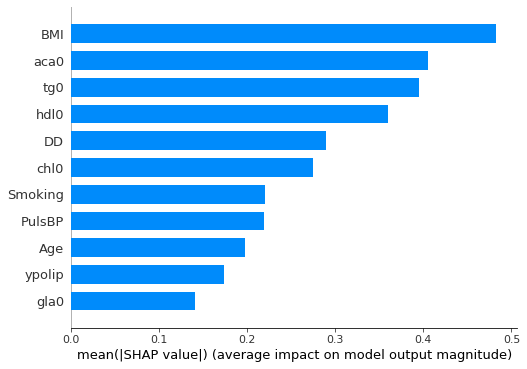

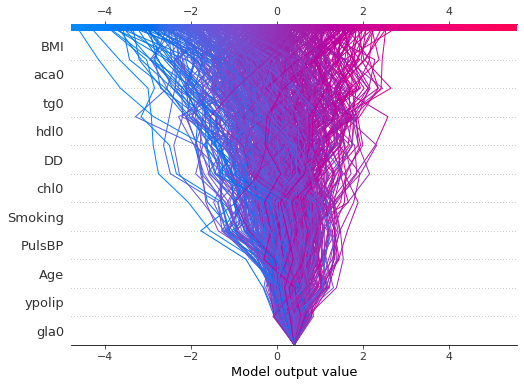

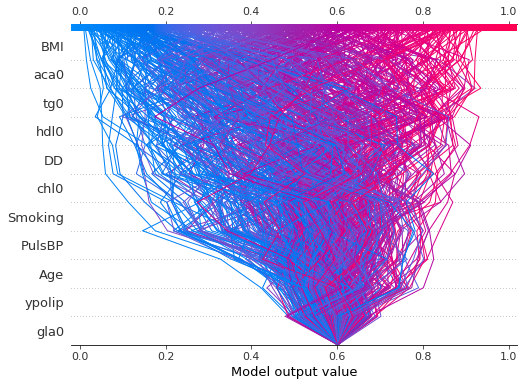

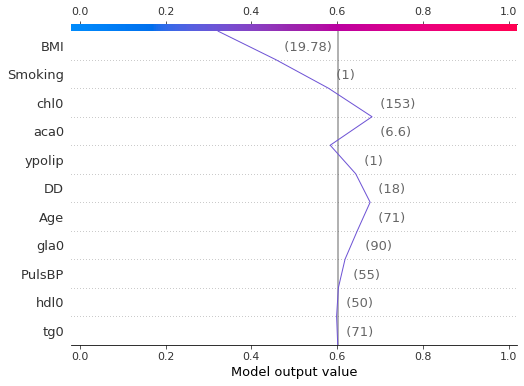

----------------------------------------------------------------
[0.5, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.75, 0, 1.0]
accuracy     0.6875
specificity  0.6802790346907994
sensitivity  0.785
auc          0.7326395173453997
brier_score  0.2233623734325444
weights      [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]
----------------------------------------------------------------


In [486]:

weights = [0.2, 0.05, 0.33, 0.13, 0.15, 0.14]

max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params,weights)

# parameters : [0.5, 2, 1000, 3, 0.5, 0.5, 1, 3, 0.75, 0, 1.0]
# accuracy : 0.6928571428571428
# spes     : 0.6860859728506787
# sens     : 0.785
# auc      : 0.7355429864253394
# weights  : [0.2, 0.1, 0.35, 0.1, 0.15, 0.1]